<a href="https://colab.research.google.com/github/nurialla2/Data4health/blob/main/Reto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asistente para identificar la cobertura de servicios de un paciente en su primera visita

In [ ]:
%pip install pandas
%pip install seaborn

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


## 1. Preprocesado de datos

In [2]:
input_dir = "./data/input"
output_dir = "./data/output"

In [ ]:
# Creamos los directorios (si no están ya creados)
%mkdir -p {input_dir}
%mkdir -p {output_dir}
# Descargamos los datos de input (si es necesario)
!wget -r -N -c -np https://physionet.org/files/eicu-crd-demo/2.0.1/
%mv physionet.org/files/eicu-crd-demo/2.0.1/* {input_dir}

### 1.1 Selección de datos

In [131]:
dfTreatment = pd.read_csv(f'{input_dir}/treatment.csv.gz', compression='gzip')
dfTreatment

,treatmentid,patientunitstayid,treatmentoffset,treatmentstring,activeupondischarge
0,9579899,242895,838,cardiovascular|arrhythmias|anticoagulant admin...,False
1,8788989,242895,512,cardiovascular|consultations|Cardiology consul...,False
2,10293108,242895,838,cardiovascular|non-operative procedures|extern...,False
3,9017080,242895,70,pulmonary|vascular disorders|VTE prophylaxis|l...,False
4,9853526,242895,70,cardiovascular|consultations|Cardiology consul...,False
...,...,...,...,...,...
38285,82612510,3352230,2176,pulmonary|ventilation and oxygenation|mechanic...,False
38286,82477425,3352230,2176,neurologic|pain / agitation / altered mentatio...,False
38287,82402829,3352231,117,cardiovascular|non-operative procedures|intraa...,False
38288,82335549,3352333,317,gastrointestinal|consultations|Gastroenterolog...,False


In [132]:
# 10 Tratamientos mas habituales
from collections import Counter

treatmentList = dfTreatment['treatmentstring'].tolist()
treatmentList2 = []
for treatment in treatmentList:
    for treat in treatment.split('|'):
        treatmentList2.append(treat)
repetitionsTreatment = Counter(treatmentList2)
sorted(repetitionsTreatment.items(), key=lambda x:x[1], reverse = True)[:10]

[('cardiovascular', 9606),
 ('pulmonary', 8409),
 ('medications', 7594),
 ('neurologic', 4667),
 ('gastrointestinal', 4474),
 ('ventilation and oxygenation', 3651),
 ('infectious diseases', 3465),
 ('pain / agitation / altered mentation', 2653),
 ('analgesics', 2322),
 ('consultations', 2296)]

In [133]:
# Filtramos por solo tratamientos cardiovasculares
dfTreatmentCardio = dfTreatment[dfTreatment['treatmentstring'].str.contains("cardiovascular")]
dfTreatmentCardio = dfTreatmentCardio[['patientunitstayid','treatmentstring','activeupondischarge']]
dfTreatmentCardio

,patientunitstayid,treatmentstring,activeupondischarge
0,242895,cardiovascular|arrhythmias|anticoagulant admin...,False
1,242895,cardiovascular|consultations|Cardiology consul...,False
2,242895,cardiovascular|non-operative procedures|extern...,False
4,242895,cardiovascular|consultations|Cardiology consul...,False
6,242895,cardiovascular|consultations|Cardiology consul...,False
...,...,...,...
38276,3352230,cardiovascular|myocardial ischemia / infarctio...,False
38278,3352230,cardiovascular|shock|vasopressors|epinephrine ...,False
38281,3352230,cardiovascular|shock|inotropic agent|dobutamine,False
38283,3352230,cardiovascular|non-operative procedures|intraa...,False


In [134]:
dfDiagnosis = pd.read_csv(f'{input_dir}/diagnosis.csv.gz', compression='gzip', na_values="nan")
dfDiagnosis = dfDiagnosis.dropna()
#dfDiagnosis = dfDiagnosis[dfDiagnosis['diagnosisstring'].str.contains("cardiovascular")]
dfDiagnosis

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,7607199,346380,False,5028,cardiovascular|ventricular disorders|hypertension,"401.9, I10",Other
1,7570429,346380,False,685,neurologic|altered mental status / pain|change...,"780.09, R41.82",Major
2,7705483,346380,True,5035,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9",Major
3,7848601,346380,True,5035,neurologic|altered mental status / pain|schizo...,"295.90, F20.9",Major
4,7451475,346380,False,5028,pulmonary|disorders of vasculature|pulmonary e...,"415.19, I26.99",Major
...,...,...,...,...,...,...,...
24973,43897237,3158501,True,11,neurologic|altered mental status / pain|enceph...,"348.31, G93.41",Other
24974,44151864,3158501,True,11,hematology|white blood cell disorders|leukocyt...,"288.8, D72.829",Other
24975,44379558,3158501,True,11,pulmonary|disorders of acid base|respiratory a...,"276.2, E87.2",Other
24976,44000639,3158501,True,11,neurologic|altered mental status / pain|delirium,"293.0, F05",Other


In [135]:
# Filtramos dataset de diagnosis por diagnóstico cardiovascular
icd9code_df = dfDiagnosis["icd9code"].str.split(",", n=1, expand=True)
icd9code_df = icd9code_df.rename(columns={0: "ic9value", 1: "ic9proc"})
dfDiagnosisIC9split = pd.concat([dfDiagnosis, icd9code_df], axis=1)
dfDiagnosisIC9split = dfDiagnosisIC9split.drop(columns=["icd9code", "ic9proc"])
dfDiagnosisFiltered = dfDiagnosisIC9split[dfDiagnosisIC9split["ic9value"].apply(lambda x: re.match(r'^-?\d+(?:\.\d+)$', x) is not None)]
dfDiagnosisFiltered = dfDiagnosisFiltered.astype({"ic9value":float})
dfDiagnosisFiltered = dfDiagnosisFiltered[dfDiagnosisFiltered["ic9value"].apply(lambda x: x >= 390 and x <= 459)]
dfDiagnosisFiltered

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,diagnosispriority,ic9value
0,7607199,346380,False,5028,cardiovascular|ventricular disorders|hypertension,Other,401.90
2,7705483,346380,True,5035,cardiovascular|shock / hypotension|hypotension,Major,458.90
4,7451475,346380,False,5028,pulmonary|disorders of vasculature|pulmonary e...,Major,415.19
5,7839760,346380,False,5028,cardiovascular|shock / hypotension|hypotension,Major,458.90
14,6176554,346380,True,5035,pulmonary|disorders of vasculature|pulmonary e...,Major,415.19
...,...,...,...,...,...,...,...
24954,26641493,1785133,True,932,cardiovascular|chest pain / ASHD|coronary arte...,Other,414.00
24955,25731810,1785133,False,92,cardiovascular|ventricular disorders|congestiv...,Primary,428.00
24958,28218607,2145788,True,26,cardiovascular|chest pain / ASHD|acute coronar...,Primary,410.90
24960,29633442,2606115,True,1209,cardiovascular|ventricular disorders|congestiv...,Major,428.00


In [136]:
# Binarizamos los diagnósticos cardiovasculares por subtipo de enfermedad cardiovascular
# Referencias: https://eciemaps.mscbs.gob.es/ecieMaps/browser/index_9_mc.html#search=&flags=111100&flagsLT=11111111&searchId=1656608221099&indiceAlfabetico=&listaTabular=id-13561-class-Cap.07&expand=0&clasification=cie9mc&version=2014
cat_2_range = {
    "fiebre_reumatica_aguda": (390,392),
    "cardiaca_reumatica_cronica": (393,398),
    "hipertension": (401,405),
    "cardiopatia_isquemica": (410.00,414.9),
    "circulacion_pulmonar": (415,417),
    "cardiaca_otros": (420,429),
    "cerebrovascular": (430,438),
    "arterios_capilares": (440,449),
    "venas_linfaticos": (451,459)
}

def is_in_range(ic9value: float):
  category = "sistema_circulatorio" # Categoría general
  for cat, range in cat_2_range.items():
    if ic9value >= range[0] and ic9value <= range[1]:
      category = cat
      break
  return category

dfDiagnosisFiltered["ic9value"] = dfDiagnosisFiltered["ic9value"].apply(lambda x: is_in_range(x))
# Nos quedamos solo con las variables de interés
dfDiagnosisFiltered = dfDiagnosisFiltered[["patientunitstayid","ic9value", "diagnosispriority"]]
dfDiagnosisFiltered


,patientunitstayid,ic9value,diagnosispriority
0,346380,hipertension,Other
2,346380,venas_linfaticos,Major
4,346380,circulacion_pulmonar,Major
5,346380,venas_linfaticos,Major
14,346380,circulacion_pulmonar,Major
...,...,...,...
24954,1785133,cardiopatia_isquemica,Other
24955,1785133,cardiaca_otros,Primary
24958,2145788,cardiopatia_isquemica,Primary
24960,2606115,cardiaca_otros,Major


In [137]:
dfPatient = pd.read_csv(f'{input_dir}/patient.csv.gz', compression='gzip')
dfPatient

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,...,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,...,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,...,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,...,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,...,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,3351763,2741766,Female,62,Caucasian,459,1108,"Fistula/abscess, surgery for (not inflammatory...",165.1,16:08:00,...,Operating Room,1,admit,134.5,133.3,19:24:00,5394,Step-Down Unit (SDU),Alive,035-10391
2516,3352230,2742186,Male,41,African American,458,1107,"CABG alone, coronary artery bypass grafting",177.8,21:21:00,...,Operating Room,2,transfer,127.0,128.5,21:34:00,4261,Telemetry,Alive,035-10089
2517,3352231,2742186,Male,41,African American,458,1104,"Infarction, acute myocardial (MI)",177.8,21:21:00,...,Direct Admit,1,admit,127.0,135.2,22:26:00,1369,Other ICU,Alive,035-10089
2518,3352333,2742269,Male,72,Caucasian,458,1111,GI obstruction,177.8,20:00:00,...,Other Hospital,1,admit,68.3,66.5,17:26:00,4166,Floor,Alive,035-10041


In [138]:
# Nos quedamos solo con las variables que queremos
dfPatientFiltered = dfPatient[['patientunitstayid', 'gender', 'age', 'admissionweight', 'admissionheight', 'ethnicity']]
dfPatientFiltered = dfPatientFiltered.dropna()
dfPatientFiltered["age"] = dfPatientFiltered["age"].apply(lambda x: 89 if x == "> 89" else x) # Por objetivos de anonimización, los hospitales escriben edades > 89"
dfPatientFiltered = dfPatientFiltered.astype({"age": int})
dfPatientFiltered

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity
1,141765,Female,87,46.5,157.5,Caucasian
2,143870,Male,76,77.5,167.0,Caucasian
3,144815,Female,34,60.3,172.7,Caucasian
4,145427,Male,61,91.7,177.8,Caucasian
6,147307,Female,55,72.5,157.5,Caucasian
...,...,...,...,...,...,...
2515,3351763,Female,62,134.5,165.1,Caucasian
2516,3352230,Male,41,127.0,177.8,African American
2517,3352231,Male,41,127.0,177.8,African American
2518,3352333,Male,72,68.3,177.8,Caucasian


In [139]:
dfVitalAperiodic = pd.read_csv(f'{input_dir}/vitalAperiodic.csv.gz', compression='gzip')
dfVitalAperiodic

,vitalaperiodicid,patientunitstayid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
0,3661418,141764,81,171.0,90.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3661424,141764,334,153.0,78.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3661417,141764,77,176.0,87.0,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3661419,141764,165,173.0,106.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3661421,141764,255,182.0,103.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274083,445476282,3353113,2206,146.0,97.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274084,445476261,3353113,1269,121.0,87.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274085,445476252,3353113,710,127.0,89.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274086,445476260,3353113,1257,123.0,82.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# Cogemos el valor promedio de los valores aperiódicos
dfVitalAperiodic = dfVitalAperiodic.groupby(['patientunitstayid'], as_index=False).mean()[['patientunitstayid', 'noninvasivesystolic',
                                                                                           'noninvasivediastolic','noninvasivemean']]

dfVitalAperiodic

,patientunitstayid,noninvasivesystolic,noninvasivediastolic,noninvasivemean
0,141764,172.750000,93.375000,125.625000
1,141765,146.033333,72.800000,98.400000
2,143870,102.500000,53.166667,74.500000
3,144815,114.388889,72.777778,88.777778
4,145427,116.666667,62.833333,83.208333
...,...,...,...,...
2326,3351763,135.985294,63.323529,89.279412
2327,3352230,117.101449,65.260870,84.304348
2328,3352231,128.000000,71.800000,91.800000
2329,3352333,146.600000,81.628571,106.228571


In [141]:
dfTreatment = pd.read_csv(f'{input_dir}/treatment.csv.gz', compression='gzip')[['patientunitstayid','treatmentstring']]
dfTreatment 

,patientunitstayid,treatmentstring
0,242895,cardiovascular|arrhythmias|anticoagulant admin...
1,242895,cardiovascular|consultations|Cardiology consul...
2,242895,cardiovascular|non-operative procedures|extern...
3,242895,pulmonary|vascular disorders|VTE prophylaxis|l...
4,242895,cardiovascular|consultations|Cardiology consul...
...,...,...
38285,3352230,pulmonary|ventilation and oxygenation|mechanic...
38286,3352230,neurologic|pain / agitation / altered mentatio...
38287,3352231,cardiovascular|non-operative procedures|intraa...
38288,3352333,gastrointestinal|consultations|Gastroenterolog...


In [142]:
dfTreatment = dfTreatment.groupby(['patientunitstayid'], as_index=False).agg({'treatmentstring': ' '.join})
dfTreatment['cardiotreatment'] = np.where(dfTreatment['treatmentstring'].str.contains("cardiovascular"), 'True', 'False')
dfTreatment = dfTreatment[['patientunitstayid', 'cardiotreatment']]
dfTreatment

,patientunitstayid,cardiotreatment
0,242895,True
1,243097,True
2,243999,True
3,244477,True
4,244707,True
...,...,...
1905,3351763,True
1906,3352230,True
1907,3352231,True
1908,3352333,False


In [143]:
# Primer merge
cleaned_df = dfPatientFiltered.merge(dfVitalAperiodic, how='left', left_on='patientunitstayid', right_on='patientunitstayid')
cleaned_df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean
0,141765,Female,87,46.5,157.5,Caucasian,146.033333,72.800000,98.400000
1,143870,Male,76,77.5,167.0,Caucasian,102.500000,53.166667,74.500000
2,144815,Female,34,60.3,172.7,Caucasian,114.388889,72.777778,88.777778
3,145427,Male,61,91.7,177.8,Caucasian,116.666667,62.833333,83.208333
4,147307,Female,55,72.5,157.5,Caucasian,128.375000,65.250000,89.062500
...,...,...,...,...,...,...,...,...,...
2261,3351763,Female,62,134.5,165.1,Caucasian,135.985294,63.323529,89.279412
2262,3352230,Male,41,127.0,177.8,African American,117.101449,65.260870,84.304348
2263,3352231,Male,41,127.0,177.8,African American,128.000000,71.800000,91.800000
2264,3352333,Male,72,68.3,177.8,Caucasian,146.600000,81.628571,106.228571


In [144]:
# Segundo merge
cleaned_df = cleaned_df.merge(dfDiagnosisFiltered, how='left', left_on='patientunitstayid', right_on='patientunitstayid')
cleaned_df["ic9value"] = cleaned_df["ic9value"].fillna("non_cardiovascular") 
cleaned_df["diagnosispriority"] = cleaned_df["diagnosispriority"].fillna("unknown") 
cleaned_df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,ic9value,diagnosispriority
0,141765,Female,87,46.5,157.5,Caucasian,146.033333,72.800000,98.400000,non_cardiovascular,unknown
1,143870,Male,76,77.5,167.0,Caucasian,102.500000,53.166667,74.500000,non_cardiovascular,unknown
2,144815,Female,34,60.3,172.7,Caucasian,114.388889,72.777778,88.777778,non_cardiovascular,unknown
3,145427,Male,61,91.7,177.8,Caucasian,116.666667,62.833333,83.208333,non_cardiovascular,unknown
4,147307,Female,55,72.5,157.5,Caucasian,128.375000,65.250000,89.062500,non_cardiovascular,unknown
...,...,...,...,...,...,...,...,...,...,...,...
5416,3352230,Male,41,127.0,177.8,African American,117.101449,65.260870,84.304348,cardiopatia_isquemica,Primary
5417,3352231,Male,41,127.0,177.8,African American,128.000000,71.800000,91.800000,cardiopatia_isquemica,Primary
5418,3352333,Male,72,68.3,177.8,Caucasian,146.600000,81.628571,106.228571,non_cardiovascular,unknown
5419,3353113,Male,50,88.0,188.0,Caucasian,136.022222,88.733333,107.511111,hipertension,Other


In [145]:
# Tercer merge
cleaned_df = cleaned_df.merge(dfTreatment, how='left', left_on='patientunitstayid', right_on='patientunitstayid')
cleaned_df = cleaned_df.dropna()
cleaned_df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,ic9value,diagnosispriority,cardiotreatment
149,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
150,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
151,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
152,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
153,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5416,3352230,Male,41,127.0,177.80,African American,117.101449,65.260870,84.304348,cardiopatia_isquemica,Primary,True
5417,3352231,Male,41,127.0,177.80,African American,128.000000,71.800000,91.800000,cardiopatia_isquemica,Primary,True
5418,3352333,Male,72,68.3,177.80,Caucasian,146.600000,81.628571,106.228571,non_cardiovascular,unknown,False
5419,3353113,Male,50,88.0,188.00,Caucasian,136.022222,88.733333,107.511111,hipertension,Other,False


In [146]:
cleaned_df.to_csv(f'{output_dir}/cleaned_df.csv', index=False)

\#TODO:
* Añadir tabla de `lab`:
  * Filtrar por offset de 0 a 1140 (primeras 24 horas)

### 1.2 Análisis exploratorio de los datos

In [147]:
target_var = "cardiotreatment"

In [148]:
cleaned_df.isna().sum()

patientunitstayid       0
gender                  0
age                     0
admissionweight         0
admissionheight         0
ethnicity               0
noninvasivesystolic     0
noninvasivediastolic    0
noninvasivemean         0
ic9value                0
diagnosispriority       0
cardiotreatment         0
dtype: int64

No tenemos nulos ✅

In [149]:
cleaned_df.dtypes

patientunitstayid         int64
gender                   object
age                       int64
admissionweight         float64
admissionheight         float64
ethnicity                object
noninvasivesystolic     float64
noninvasivediastolic    float64
noninvasivemean         float64
ic9value                 object
diagnosispriority        object
cardiotreatment          object
dtype: object

`treated` lo detecta como `object` en vez de como bool ❓❓

In [150]:
cleaned_df.describe()

,patientunitstayid,age,admissionweight,admissionheight,noninvasivesystolic,noninvasivediastolic,noninvasivemean
count,4.564000e+03,4564.000000,4564.000000,4564.000000,4564.000000,4564.000000,4564.000000
mean,1.803880e+06,66.275416,87.445898,169.861374,120.294388,65.355959,80.492448
std,1.047878e+06,15.714224,26.804198,16.229579,18.289279,10.653042,12.144334
min,2.428950e+05,18.000000,32.700000,0.300000,49.454545,20.727273,28.181818
25%,8.510930e+05,56.000000,67.122500,162.600000,108.489362,58.243687,72.375000
50%,1.746645e+06,69.000000,84.100000,170.200000,117.497634,64.615385,78.608943
75%,2.803818e+06,78.000000,103.870000,177.800000,132.306122,72.324675,87.680533
max,3.353113e+06,89.000000,293.930000,600.000000,187.362712,119.444444,138.555556


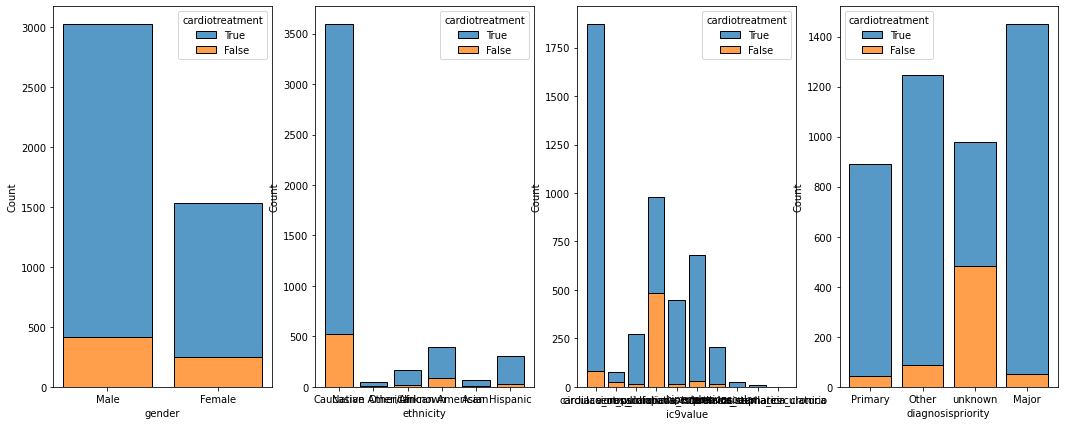

In [155]:
# Análisis de variables categóricas
categorical_vars = ("gender", "ethnicity", "ic9value", "diagnosispriority")
fig, ax = plt.subplots(nrows=1, ncols=len(categorical_vars), figsize=(18,7))
for i, var in enumerate(categorical_vars):
  sns.histplot(cleaned_df, x=var, ax=ax[i], discrete=True, shrink=0.8, hue=target_var, multiple="stack")
  ax[i].set_xticks(sorted(cleaned_df[var].unique()))

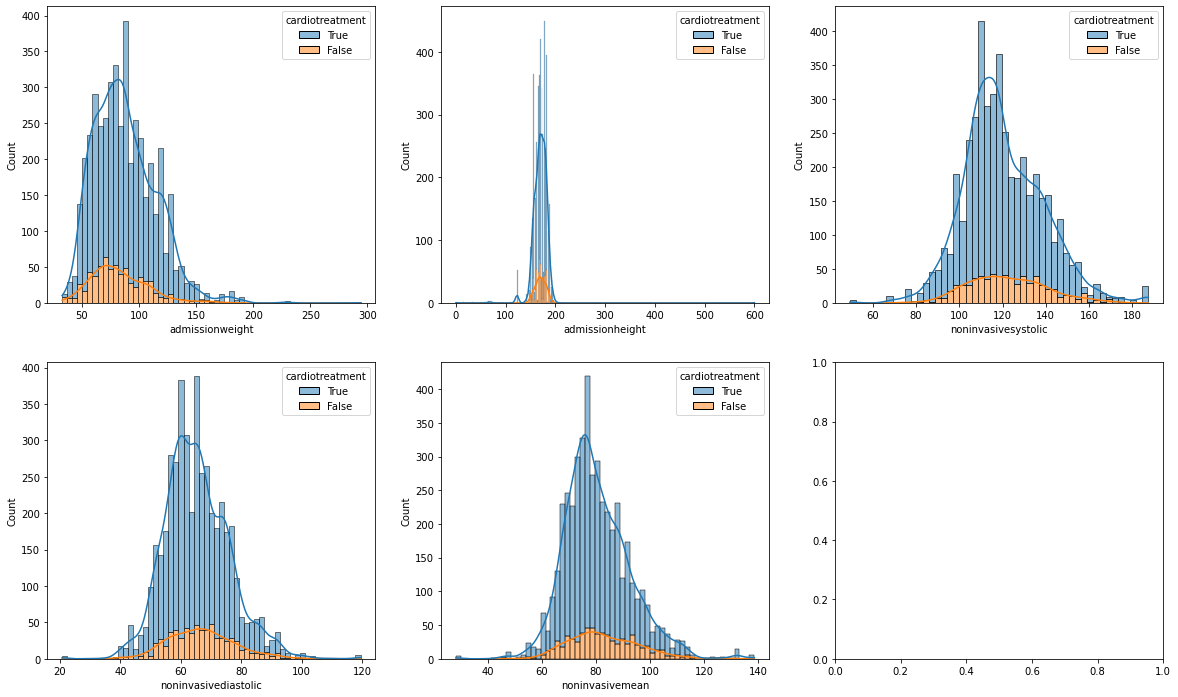

In [152]:
# Análisis de variables numéricas
numerical_vars = ("admissionweight", "admissionheight", "noninvasivesystolic", "noninvasivediastolic",	"noninvasivemean")
nrows=2
ncols=math.ceil(len(numerical_vars)/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
for i, var in enumerate(numerical_vars):
  sns.histplot(cleaned_df, x=var, ax=ax[i//ncols, i%ncols], kde=True, hue=target_var, multiple="stack")

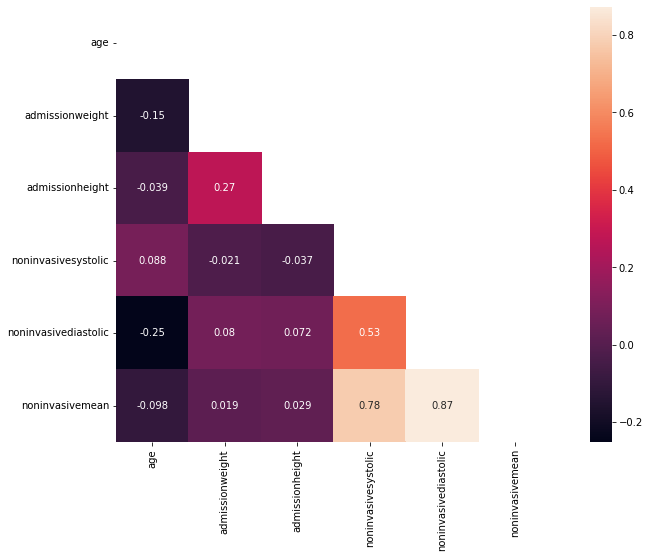

In [153]:
# Análisis de correlaciones
corr = cleaned_df.drop("patientunitstayid", axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Esto es simplemente para mostras la mitad diagonal del heatmap
plt.figure(figsize=(14,8))
sns.heatmap(corr, square=True, mask=mask, annot=True)

Estas 3 variables tienen una distribución muy parecida y una correlación bastante alta entre ellas `noninvasivesystolic`,	`noninvasivediastolic`,	`noninvasivemean` 🚨

In [154]:
#TODO: pasar variables categóricas a hot-encodedn -> Solo si el modelo no acepta categóricas

## 2. Model selection

Modelos:
  * Random Forest or Decision Trees
  * Regresión logística o GAN

https://github.com/theonesp/ml_mort_cardiac/blob/master/analysis/training/training_models_full.ipynb


Explicabilidad:
  * Random forest: features importances, decision tree a secas
  * Regresión logística: odds-ratio -> https://www.researchgate.net/profile/Hilde-Van-De-Velde/publication/5461446/figure/fig1/AS:278659769356296@1443449074299/Forest-plot-for-the-diagnostic-odds-ratios-Circles-represent-individual-studies-The.png

Utilizar AUROC como valor de rendimiento